In [3]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
%autoreload
import sys
sys.path.append("..") #this is to add the avobe folder to the package directory
import geopandas as gpd
import shapely
import pandas as pd
import numpy as np
import fiona
import rasterio
import rasterio.mask
import rasterio.merge
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.fill import fillnodata
from rasterio.plot import show
import nexus_tool.weap_tools as wp
import os
import matplotlib.pyplot as plt
from shutil import copyfile
from datetime import date

## Reading files

In [5]:
provinces = gpd.read_file('Data/GIS/Admin/Provinces.gpkg', encoding='utf-8')
groundwater = gpd.read_file('Data/Schematic/Groundwater.kml', encoding='utf-8')
wwtp = gpd.read_file('Data/Schematic/Wastewater Treatment Plants.kml', encoding='utf-8')
other_supply = gpd.read_file('Data/Schematic/Other Supplies.kml', encoding='utf-8')
river_withdrawals = gpd.read_file('Data/Schematic/River Withdrawals.kml', encoding='utf-8')
demand_sites = gpd.read_file('Data/Schematic/Demand Sites.kml', encoding='utf-8')
catchments = gpd.read_file('Data/Schematic/Catchments.kml', encoding='utf-8')
diversion = gpd.read_file('Data/Schematic/Diversions.kml', encoding='utf-8')
reservoirs = gpd.read_file('Data/Schematic/Reservoirs.kml', encoding='utf-8')
links = gpd.read_file('Data/Schematic/Transmission Links.kml', encoding='utf-8')

## Converting geometries and dropping unecesary columns

In [6]:
for gdf in [groundwater, wwtp, other_supply, river_withdrawals,
            demand_sites, catchments, diversion, reservoirs, links]:
    gdf['geometry'] = wp.polyz_to_poly(gdf)
    gdf.drop(columns='Description', inplace=True)

In [7]:
for gdf in [groundwater, wwtp, other_supply, river_withdrawals,
            reservoirs, demand_sites, catchments]:
    gdf.rename(columns={'Name': 'point'}, inplace=True)

links.rename(columns={'Name': 'links'}, inplace=True)
diversion.rename(columns={'Name': 'diversion'}, inplace=True)

## Defining types

In [8]:
groundwater['type'] = 'Groundwater supply'
wwtp['type'] = 'WWTP'
other_supply['type'] = 'Other supply'
river_withdrawals['type'] = 'Surfacewater withdrawal'
reservoirs['type'] = 'Reservoir supply'
catchments['type'] = 'Catchment'
demand_sites['type'] = 'Demand site'
diversion['type'] = 'Transmission Pipeline'
links['type'] = 'Transmission links'

In [9]:
# other_supply['point'] = 'Prelevement 3'
supply_points = groundwater.append([other_supply, reservoirs, river_withdrawals], ignore_index=True, sort=False)
demand_points = demand_sites.append(catchments, ignore_index=True, sort=False)
links['links'] = links.links.str.replace('Groundwater','GW')
links['links'] = links.links.str.replace('Grounwater','GW')
links['links'] = links.links.str.replace('GW of ','')
links['links'] = links.links.str.replace('GW ','')
links['links'] = links.links.str.strip()
links['links'] = links.links.str.replace(' El Guerdane',' I_El Guerdane')

In [10]:
demand_links = gpd.sjoin(demand_points, links, how='inner', op='intersects')
supply_links = gpd.sjoin(supply_points, links, how='inner', op='intersects')

In [11]:
demand_links.rename(columns={'type_left': 'type'}, inplace=True)
demand_links.drop(columns=['type_right', 'index_right'], inplace=True)
supply_links.rename(columns={'type_left': 'type'}, inplace=True)
supply_links.drop(columns=['type_right', 'index_right'], inplace=True)

In [12]:
dff = gpd.sjoin(demand_links, provinces[['Province','geometry']], how='inner', op='within')
dff.drop(columns=['index_right'], inplace=True)
df_temp = demand_links.loc[~demand_links.point.isin(dff.point.unique())].copy()
df_temp['Province'] = 'Tiznit'
demand_links = dff.append(df_temp, sort=False)

In [13]:
dff = gpd.sjoin(supply_links, provinces[['Province','geometry']], how='inner', op='within')
dff.drop(columns=['index_right'], inplace=True)
df_temp = supply_links.loc[~supply_links.point.isin(dff.point.unique())].copy()
supply_links = dff.append(df_temp, sort=False)
df_temp['Province'] = 'Chtouka-Aït Baha'
supply_links = dff.append(df_temp, sort=False)

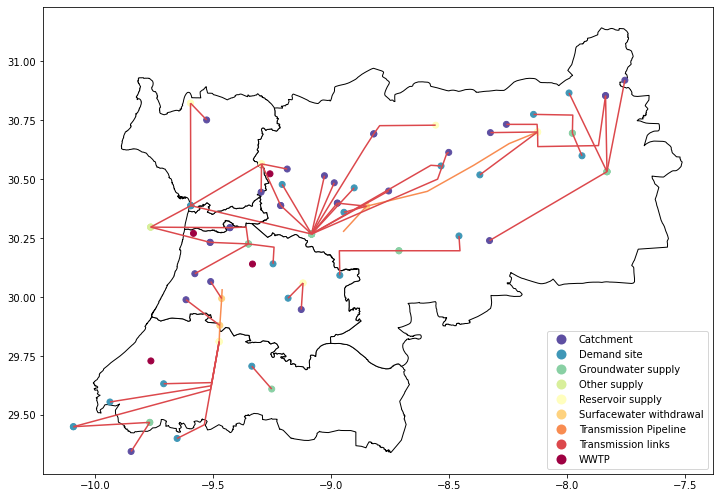

In [14]:
base = provinces.plot(color='white', edgecolor='black', figsize=(12, 12))
data = demand_links.append([supply_links, wwtp, diversion, links], ignore_index=True, sort=False)
data.plot(ax=base, column='type', cmap='Spectral_r', legend=True)
plt.show()

In [15]:
out_image, out_meta = wp.mask_raster('Data/GIS/wtd/Africa_model_wtd_v2.nc', 
                                  'Data/GIS/Admin/Provinces.gpkg', 'EPSG:4326')
       
with rasterio.open("Data/GIS/wtd//Souss-Massa WTD.tif", "w", **out_meta) as dest:
    dest.write(out_image)

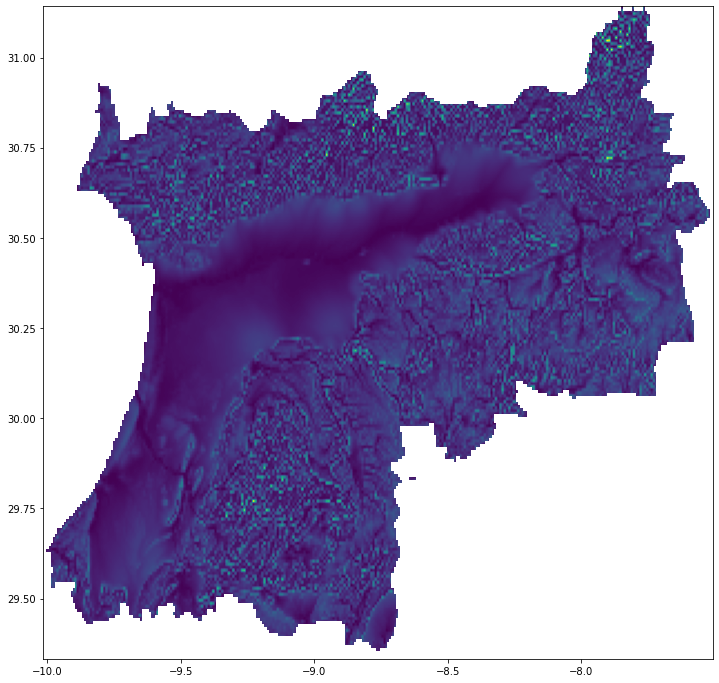

In [16]:
with rasterio.open("Data/GIS/wtd//Souss-Massa WTD.tif") as src:
    fig, ax = plt.subplots(figsize=(12, 12))
    show(src, ax=ax, aspect='auto')

In [17]:
groundwater['wtd_m'] = wp.sample_raster("Data/GIS/wtd/Africa_model_wtd_v2.nc", 
                                         groundwater)
groundwater.loc[groundwater.point=='Souss GW','wtd_m'] = 170
groundwater.loc[groundwater.point=='Chtouka GW','wtd_m'] = 85

In [18]:
groundwater

,point,geometry,type,wtd_m
0,AAM GW,POINT (-9.25258 29.60961),Groundwater supply,44.934959
1,Anti Atlas GW,POINT (-8.71300 30.19612),Groundwater supply,99.466217
2,Chtouka GW,POINT (-9.35136 30.22505),Groundwater supply,85.000000
3,Haut Montagne Souss GW,POINT (-7.83061 30.53151),Groundwater supply,82.050613
4,Nappe Aluviale de Souss GW,POINT (-7.97735 30.69469),Groundwater supply,30.735268
5,Souss GW,POINT (-9.08357 30.26714),Groundwater supply,170.000000
6,Tiznit GW,POINT (-9.76978 29.46813),Groundwater supply,50.487309


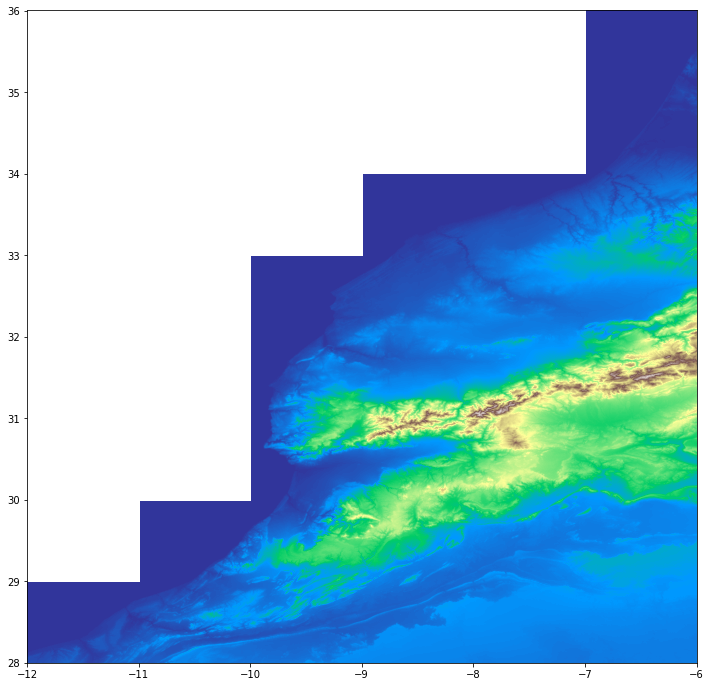

In [19]:
wp.merge_rasters('Data/GIS/DEM/*', 'EPSG:4326', 
                 "Data/GIS/DEM//Souss-Massa DEM.tif")

with rasterio.open("Data/GIS/DEM//Souss-Massa DEM.tif") as src:
    fig, ax = plt.subplots(figsize=(12, 12))
    show(src, ax=ax, aspect='auto', cmap='terrain')

In [20]:
supply_links['elevation'] = wp.sample_raster("Data/GIS/DEM//Souss-Massa DEM.tif", 
                                               supply_links)
demand_links['elevation'] = wp.sample_raster("Data/GIS/DEM//Souss-Massa DEM.tif", 
                                               demand_links)
wwtp['elevation'] = wp.sample_raster("Data/GIS/DEM//Souss-Massa DEM.tif", 
                                       wwtp)

In [21]:
diversions = gpd.sjoin(diversion, reservoirs, how='inner', op='intersects')
diversions.drop(columns=['index_right'], inplace=True)
diversions.rename(columns={'type_right': 'type_supply'}, inplace=True)
diversions = gpd.sjoin(diversions, river_withdrawals, how='inner', op='intersects')
diversions.drop(columns=['index_right'], inplace=True)
diversions.rename(columns={'point_left': 'Supply point', 'point_right': 'Demand point',
                           'type_left': 'type', 'type': 'type_demand'}, inplace=True)

In [22]:
dff1 = river_withdrawals.loc[river_withdrawals.point.isin(diversions['Demand point'])].copy()
dff1['diversion'] = dff1.point.map(diversions.set_index('Demand point').diversion)
dff1['elevation'] = wp.sample_raster("Data/GIS/DEM//Souss-Massa DEM.tif", 
                                       dff1)

In [23]:
dff2 = reservoirs.loc[reservoirs.point.isin(diversions['Supply point'])].copy()
dff2['diversion'] = dff2.point.map(diversions.groupby('Supply point').agg({'diversion': 'first'})['diversion'])
dff2['elevation'] = wp.sample_raster("Data/GIS/DEM//Souss-Massa DEM.tif", 
                                       dff2)
MerchidSudMoroc = 26192
dff2.to_crs(f'epsg:{MerchidSudMoroc}', inplace=True)

In [24]:
dff1.to_crs(f'epsg:{MerchidSudMoroc}', inplace=True)
dff1.set_index('diversion', inplace=True)
dff1['distance'] = dff1.distance(dff2.set_index('diversion')).copy()

In [25]:
diversions['distance'] = diversions['Demand point'].map(dff1.set_index('point')['distance'])
diversions['elevation_diff'] = diversions['Demand point'].map(dff1.set_index('point')['elevation']) - \
                               diversions['Supply point'].map(dff2.set_index('point')['elevation'])

In [26]:
all_points = supply_links.append(demand_links, sort=False, ignore_index=True)
all_points.drop_duplicates(subset="point", inplace=True)

In [27]:
files_dict = {'Desalination': {'Trend': ['SoussMassa Results - Reference.xlsx'],
                               'Climate Change': ['SoussMassa Results - Reference CC.xlsx']},
              'Reference': {'Trend': ['SoussMassa Results - No Desal.xlsx'],
                            'Climate Change': ['SoussMassa Results - No Desal CC.xlsx']},
              'Irrigation intensification': {'Trend': ['SoussMassa Results - Irrigation Intensification.xlsx'],
                                             'Climate Change': ['SoussMassa Results - Irrigation Intensification CC.xlsx']}
             }

raw_data = os.path.join('Data', 'WEAP Results')
results_path = os.path.join('Data', 'Processed Results')
wp.create_folder(results_path)
for scenario, files in files_dict.items():
    scenario_path = os.path.join(results_path, scenario)
    wp.create_folder(scenario_path)
    for folder, file in files.items():
        folder_path = os.path.join(scenario_path, folder)
        wp.create_folder(folder_path)
        for i, f in enumerate(file):
            dst = os.path.join(folder_path, f'level_{i+1}')
            wp.create_folder(dst)
            copyfile(os.path.join(raw_data, f), os.path.join(dst, 'results.xlsx'))

In [28]:
def integrate_data(sheet_name, category, dff_dict, var_name='links', target='point'):
    df = data.parse(sheet_name, skiprows=3)
    df.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
    df.columns = df.columns.str.replace('"', '').str.strip()

    df.columns = df.columns.str.replace('Groundwater','GW')
    df.columns = df.columns.str.replace('Grounwater','GW')
    df.columns = df.columns.str.replace('GW of ','')
    df.columns = df.columns.str.replace('GW ','')

    for link in demand_links.links:
        if np.array(df.columns[df.columns.str.contains(link)]).size > 0:
            df.rename(columns={df.columns[df.columns.str.contains(link)][0]: link}, inplace=True)

    df = df.loc[df.Date!='Sum']
    df.Date = pd.to_datetime(df.Date)
    df['Year'] = df.Date.dt.year
    df['Month'] = df.Date.dt.month
    
    drop_columns = []
    if 'Sum' in df.columns:
        drop_columns.append('Sum')
    df.drop(columns=drop_columns, inplace=True)

    df = df.melt(id_vars=['Date', 'Year', 'Month'])
    
    for name, dff in dff_dict.items():
        df_temp = dff.set_index(var_name)
        if var_name!=target:
            df[name] = df.variable.map(df_temp[target])
    
    df['type'] = category
    df.rename(columns={'variable': var_name}, inplace=True)
    if df.loc[~df[var_name].isin(df.dropna()[var_name].unique()),var_name].unique().size > 0:
        print("The following links were not found:")
        print(df.loc[~df[var_name].isin(df.dropna()[var_name].unique()),var_name].unique())
    return df

In [29]:
scenarios = ['Reference', 'Desalination', 'Irrigation intensification']
# scenarios = ['Reference']
processed_data = os.path.join('Data', 'Merged data')
wp.create_folder(processed_data)
for scenario in scenarios:
    scenario_folder = os.path.join(results_path, scenario)
    wp.create_folder(os.path.join(processed_data, scenario))
    for sub_scenario in os.listdir(scenario_folder):
        sub_scenario_folder = os.path.join(scenario_folder, sub_scenario)
        wp.create_folder(os.path.join(processed_data, scenario, sub_scenario))
        for level in os.listdir(sub_scenario_folder):
            output_folder = os.path.join(processed_data, scenario, sub_scenario, level)
            wp.create_folder(output_folder)
            file = os.path.join(sub_scenario_folder, level, 'results.xlsx')
            data = pd.ExcelFile(file)
            
            sheet_names = {'Desalination': 'DS Agriculture', 
                           'GP Irrigation': 'GW Agriculture', 
                           'GP Domestic': 'GW Domestic',
                           'MAR': 'Aquifer recharge',
                           'SW Irrigation': 'SW Agriculture',
                           'SW Domestic': 'SW Domestic'}
            
            df = pd.DataFrame()
            for sheet_name, category in sheet_names.items():
                df = df.append(integrate_data(sheet_name, category, {'Demand point': demand_links, 
                                                                     'Supply point': supply_links}))
            
            df['wtd'] = df['Supply point'].map(groundwater.set_index('point')['wtd_m'])
            
            wtd_change = integrate_data('GW Change in Elev', 'GW wtd', {'GW': groundwater}, 'point', 'point')
            df.set_index(['Date', 'Supply point'], inplace=True)
            df['wtd'] -= df.index.map(wtd_change.set_index(['Date', 'point']).value)
            df.reset_index(inplace=True)
            
            df['elevation_diff'] = df.links.map(demand_links.set_index('links').elevation) - \
                                   df.links.map(supply_links.set_index('links').elevation)
            
            dff = df.loc[df['Supply point'].isin(diversions['Demand point'].unique())].groupby(['Date','Supply point','Year','Month']).agg({'value': 'sum'}).reset_index()
            dff.rename(columns={'Supply point': 'Demand point'}, inplace=True)
            dff['Supply point'] = dff['Demand point'].map(diversions.set_index('Demand point')['Supply point'])
            dff['elevation_diff'] = dff['Demand point'].map(diversions.set_index('Demand point')['elevation_diff'])
            dff['Province'] = dff['Supply point'].map(supply_links.drop_duplicates('point').set_index('point')['Province'])
            dff['type'] = 'Transmission Pipeline'
            
            df = df.append(dff, sort=False, ignore_index=True)
            
            df.loc[df.Province.isna(),'Province'] = df['Demand point'].map(demand_links.drop_duplicates('point').set_index('point')['Province'])
            
            supply = gpd.GeoDataFrame(geometry=df['Supply point'].map(all_points.set_index('point').geometry), crs='epsg:4326')
#             supply.dropna(inplace=True)
            supply.to_crs(f'epsg:{MerchidSudMoroc}', inplace=True)
            demand = gpd.GeoDataFrame(geometry=df['Demand point'].map(all_points.set_index('point').geometry), crs='epsg:4326')
#             demand.dropna(inplace=True)
            demand.to_crs(f'epsg:{MerchidSudMoroc}', inplace=True)
            df['distance'] = supply.distance(demand)
            
            df.loc[df['type'].str.contains('GW'), 'distance'] = df.loc[df['type'].str.contains('GW'), 'wtd']
            df.loc[df['type'].str.contains('GW'), 'elevation_diff'] = df.loc[df['type'].str.contains('GW'), 'wtd']
            
            #temporal fix due to inacurate pleasment of demand points
            df.loc[df['type'].str.contains('SW'), 'distance'] = np.nan
            df.loc[df['type'].str.contains('SW'), 'elevation_diff'] = np.nan
            
            #define the delainated water for agriculture and for domestic use
            df.loc[(df['type']=='DS Agriculture')&(df['Demand point']=='Agadir'), 'type'] = 'DS Domestic'
            
            df_wwtp = integrate_data('WWTP Inflow', 'wwtp', {'WWTP': wwtp}, 'point', 'point')
            
            sheet_names = {'AgWaterDemand': 'Agriculture', 
                           'DomWaterDemand': 'Domestic'}

            df_required = pd.DataFrame()
            for sheet_name, category in sheet_names.items():
                df_required = df_required.append(integrate_data(sheet_name, category, {'Demand point': demand_links}, 'point', 'point'))
            
            df['water_required'] = df.set_index(['Date','Demand point']).index.map(df_required.set_index(['Date','point']).value)
            
            df_unmet_month = 1 - (df.groupby(['Date', 'Demand point'])['value'].sum() / \
                           df.groupby(['Date', 'Demand point'])['water_required'].mean())
            
            df['unmet_demand_month'] = df.set_index(['Date','Demand point']).index.map(df_unmet_month)
            
            water_req_year = df.groupby(['Year', 'Date', 'Demand point'])['water_required'].mean().reset_index().groupby(['Year', 'Demand point'])['water_required'].sum()
            
            df_unmet_year = 1 - (df.groupby(['Year', 'Demand point'])['value'].sum() / \
                                 water_req_year)
            
            df['unmet_demand_year'] = df.set_index(['Year','Demand point']).index.map(df_unmet_year)
            
            df.loc[df.unmet_demand_year<0, 'unmet_demand_year'] = 0
            df.loc[df.unmet_demand_month<0, 'unmet_demand_month'] = 0
            
            df.fillna({'unmet_demand_year': 0, 'unmet_demand_month': 0}, inplace=True)
            
            df.to_csv(os.path.join(output_folder, 'demand_data.gz'), index=False)
            df_wwtp.to_csv(os.path.join(output_folder, 'wwtp_inflow.gz'), index=False)            

In [30]:
df['type'].unique()

array(['DS Domestic', 'DS Agriculture', 'GW Agriculture', 'GW Domestic',
       'Aquifer recharge', 'SW Agriculture', 'SW Domestic',
       'Transmission Pipeline'], dtype=object)

In [31]:
water_req_year

Year  Demand point     
2019  AEP Rural                  0.00
      AEP Taroudant        1991304.00
      AEPR                       9.15
      AEPR 2                     9.15
      AEP_Aoulouz           136539.60
                              ...    
2050  Tafraout              186266.60
      Tiznit               4083261.00
      Withdrawal Node 1          0.00
      Withdrawal Node 2          0.00
      Withdrawal Node 3          0.00
Name: water_required, Length: 1376, dtype: float64

In [32]:
# df.groupby(['Date','Demand point']).unmet_demand_month.mean().reset_index().pivot('Date', 'Demand point', 'unmet_demand_month').plot(subplots=True,
#                                                                                                                          figsize=(16,100),
#                                                                                                                                   sharey=True)

In [33]:
df

,Date,Supply point,Year,Month,links,value,Demand point,type,wtd,elevation_diff,Province,distance,water_required,unmet_demand_month,unmet_demand_year
0,2019-09-01,Desalination,2019,9,Transmission Link from Desalination to Agadir,0.00,Agadir,DS Domestic,NaN,10.0,Agadir-Ida ou Tanane,19230.740029,5721058.0,0.0,0.0
1,2019-10-01,Desalination,2019,10,Transmission Link from Desalination to Agadir,0.00,Agadir,DS Domestic,NaN,10.0,Agadir-Ida ou Tanane,19230.740029,5911760.0,0.0,0.0
2,2019-11-01,Desalination,2019,11,Transmission Link from Desalination to Agadir,0.00,Agadir,DS Domestic,NaN,10.0,Agadir-Ida ou Tanane,19230.740029,5721058.0,0.0,0.0
3,2019-12-01,Desalination,2019,12,Transmission Link from Desalination to Agadir,0.00,Agadir,DS Domestic,NaN,10.0,Agadir-Ida ou Tanane,19230.740029,5911760.0,0.0,0.0
4,2020-01-01,Desalination,2020,1,Transmission Link from Desalination to Agadir,0.00,Agadir,DS Domestic,NaN,10.0,Agadir-Ida ou Tanane,19230.740029,5911760.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19711,2050-07-01,Youssef Ben Tachefine,2050,7,NaN,4793759.00,Withdrawal Node 2,Transmission Pipeline,NaN,60.0,Tiznit,20253.108322,NaN,0.0,0.0
19712,2050-07-01,Youssef Ben Tachefine,2050,7,NaN,1170725.00,Withdrawal Node 3,Transmission Pipeline,NaN,69.0,Tiznit,7614.098123,NaN,0.0,0.0
19713,2050-08-01,Complexe Aoulouz Mokhtar Soussi,2050,8,NaN,207246.54,Withdrawal Node 1,Transmission Pipeline,NaN,-466.0,Taroudannt,77847.692844,NaN,0.0,0.0
19714,2050-08-01,Youssef Ben Tachefine,2050,8,NaN,4361238.00,Withdrawal Node 2,Transmission Pipeline,NaN,60.0,Tiznit,20253.108322,NaN,0.0,0.0


The previous printed lines will show transmision links if there was any missmatch between the names in the schematic and the names in the data.

The following block will print the transmission links that are not found in the results. In the current data these are 4, I already rised this with Biran and he said he will fix it for the scenario runs.

In [34]:
demand_links.loc[~demand_links['links'].isin(df['links'].unique()), 'links'].unique()

array([], dtype=object)

In [35]:
df.head()

,Date,Supply point,Year,Month,links,value,Demand point,type,wtd,elevation_diff,Province,distance,water_required,unmet_demand_month,unmet_demand_year
0,2019-09-01,Desalination,2019,9,Transmission Link from Desalination to Agadir,0.0,Agadir,DS Domestic,NaN,10.0,Agadir-Ida ou Tanane,19230.740029,5721058.0,0.0,0.0
1,2019-10-01,Desalination,2019,10,Transmission Link from Desalination to Agadir,0.0,Agadir,DS Domestic,NaN,10.0,Agadir-Ida ou Tanane,19230.740029,5911760.0,0.0,0.0
2,2019-11-01,Desalination,2019,11,Transmission Link from Desalination to Agadir,0.0,Agadir,DS Domestic,NaN,10.0,Agadir-Ida ou Tanane,19230.740029,5721058.0,0.0,0.0
3,2019-12-01,Desalination,2019,12,Transmission Link from Desalination to Agadir,0.0,Agadir,DS Domestic,NaN,10.0,Agadir-Ida ou Tanane,19230.740029,5911760.0,0.0,0.0
4,2020-01-01,Desalination,2020,1,Transmission Link from Desalination to Agadir,0.0,Agadir,DS Domestic,NaN,10.0,Agadir-Ida ou Tanane,19230.740029,5911760.0,0.0,0.0


In [36]:
folder = r'../Morocco dashboard/spatial_data'
wp.create_folder(folder)
demand_links.to_file(os.path.join(folder, 'Demand_points.gpkg'), driver="GPKG")
supply_links.to_file(os.path.join(folder, 'Supply_points.gpkg'), driver="GPKG")
wwtp.to_file(os.path.join(folder, 'wwtp.gpkg'), driver="GPKG")
diversions.to_file(os.path.join(folder, 'Pipelines.gpkg'), driver="GPKG")
groundwater.to_file(os.path.join(folder, 'Groundwater.gpkg'), driver="GPKG")
all_points.to_file(os.path.join(folder, 'all_points.gpkg'), driver="GPKG")